6.8.1.1 ARMA(1,1) process. 80% train, 20% test. 

In [1]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm_notebook
from itertools import product

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
np.random.seed(42)

ar1 = np.array([1, -0.33])  # Coefficient with opposite sign than in equation
ma1 = np.array([1, 0.9])    # Coefficient with same sign than in equation

ARMA_1_1 = ArmaProcess(ar1, ma1).generate_sample(nsample=1000)

In [4]:
df_diff = pd.DataFrame({'values': ARMA_1_1})

train = df_diff[:-200]
test = df_diff[-200:]

print(len(train))
print(len(test))

800
200


6.8.1.2 Rolling Forecast method, predict the test set

In [5]:
def rolling_forecast(df: pd.DataFrame, train_len: int, horizon: int, window: int, method: str) -> list:
    
    total_len = train_len + horizon
    end_idx = train_len
    
    if method == 'mean':
        pred_mean = []
        
        for i in range(train_len, total_len, window):
            mean = np.mean(df[:i].values)
            pred_mean.extend(mean for _ in range(window))
            
        return pred_mean

    elif method == 'last':
        pred_last_value = []
        
        for i in range(train_len, total_len, window):
            last_value = df[:i].iloc[-1].values[0]
            pred_last_value.extend(last_value for _ in range(window))
            
        return pred_last_value
    
    elif method == 'ARMA':
        pred_ARMA = []
        
        for i in range(train_len, total_len, window):
            model = SARIMAX(df[:i], order=(2,0,2))
            res = model.fit(disp=False)
            predictions = res.get_prediction(0, i + window - 1)
            oos_pred = predictions.predicted_mean.iloc[-window:]
            pred_ARMA.extend(oos_pred)
            
        return pred_ARMA

In [6]:
TRAIN_LEN = len(train)
HORIZON = len(test)
WINDOW = 1

pred_mean = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'mean')
pred_last_value = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'last')
pred_ARMA = rolling_forecast(df_diff, TRAIN_LEN, HORIZON, WINDOW, 'ARMA')

test.loc[:, 'pred_mean'] = pred_mean
test.loc[:, 'pred_last_value'] = pred_last_value
test.loc[:, 'pred_ARMA'] = pred_ARMA

test.head()

6.8.1.3 Plot Forecasts

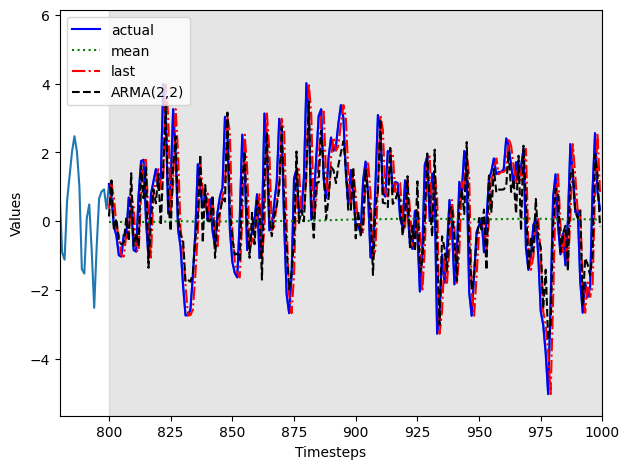

In [8]:
fig, ax = plt.subplots()

ax.plot(df_diff['values'])
ax.plot(test['values'], 'b-', label='actual')
ax.plot(test['pred_mean'], 'g:', label='mean')
ax.plot(test['pred_last_value'], 'r-.', label='last')
ax.plot(test['pred_ARMA'], 'k--', label='ARMA(2,2)')

ax.legend(loc=2)

ax.set_xlabel('Timesteps')
ax.set_ylabel('Values')

ax.axvspan(800, 1000, color='#808080', alpha=0.2)

ax.set_xlim(780, 1000)

plt.tight_layout()

6.8.1.4 Evaluate using MSE

In [9]:
mse_mean = mean_squared_error(test['values'], test['pred_mean'])
mse_last = mean_squared_error(test['values'], test['pred_last_value'])
mse_ARMA = mean_squared_error(test['values'], test['pred_ARMA'])

print(mse_mean, mse_last, mse_ARMA)

2.6792528451659092 1.6761458178498734 0.9323140490083446


ARMA(1,1) is the best method